In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [5]:
data_dir="C:\\Users\\HEMA SAI VENKAT\\Desktop\\project IV\\TK55671\\CODE\\data"

In [6]:
Plants=[]
for file in os.listdir(data_dir):
    Plants+=[file]
print(Plants)
print(len(Plants))

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
11


In [7]:
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(Plants):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'LabelID', 'Label'])
train.head()

,File,LabelID,Label
0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
1,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
2,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
3,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
4,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...


In [8]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train.tail()

,File,LabelID,Label
5109,Tomato___Late_blight/7ee00267-be66-4b6a-a207-0...,9,Tomato___Late_blight
5110,Corn_(maize)___Common_rust_/img (15).JPG,1,Corn_(maize)___Common_rust_
5111,Potato___Late_blight/bd70c718-5846-42a1-8b05-2...,6,Potato___Late_blight
5112,Tomato___healthy/img (182).JPG,8,Tomato___healthy
5113,Corn_(maize)___Common_rust_/img (75).JPG,1,Corn_(maize)___Common_rust_


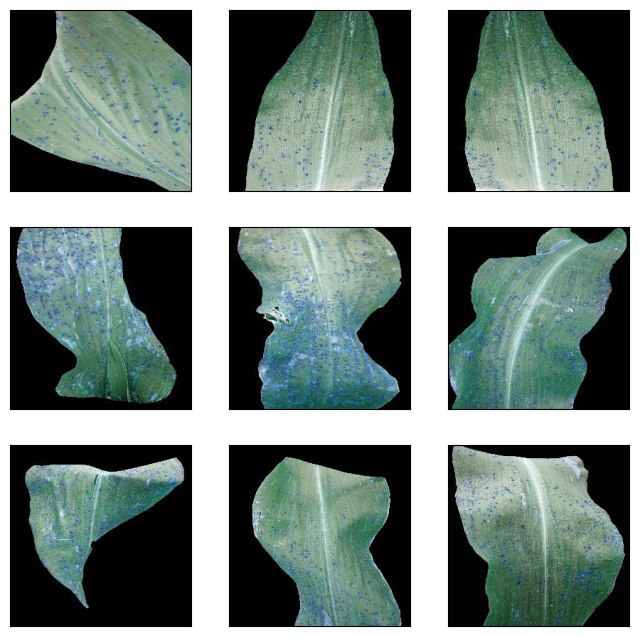

In [9]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Corn_(maize)___Common_rust_', 3, 3)

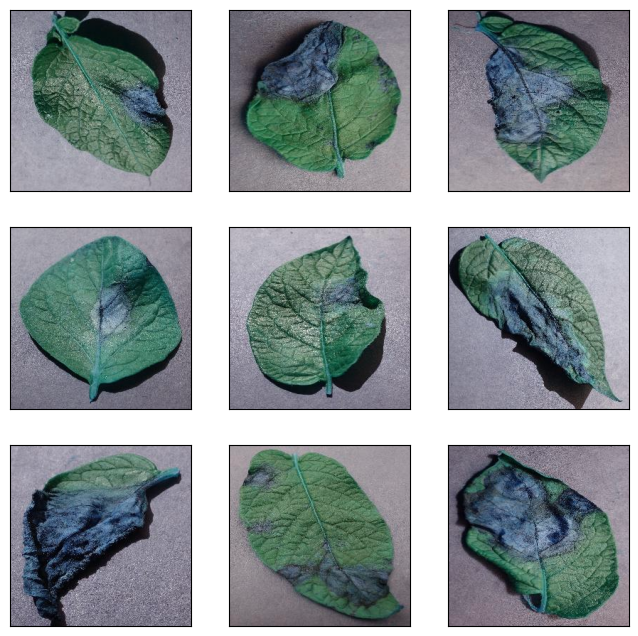

In [10]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Potato___Late_blight', 3, 3)

In [11]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)


train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    class_mode='categorical')

Found 5114 images belonging to 11 classes.


In [12]:
IMAGE_SIZE = 128


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))


def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [13]:
x_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        x_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))


x_train = x_train / 255.

num_classes=11
y_train = train['LabelID'].values
y_train = to_categorical(y_train,num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=SEED)
print('Train Shape: {}'.format(X_train.shape))
print('Train Shape: {}'.format(Y_train.shape))

0it [00:00, ?it/s]

5114it [00:59, 86.11it/s]


Train Shape: (3579, 128, 128, 3)
Train Shape: (3579, 11)


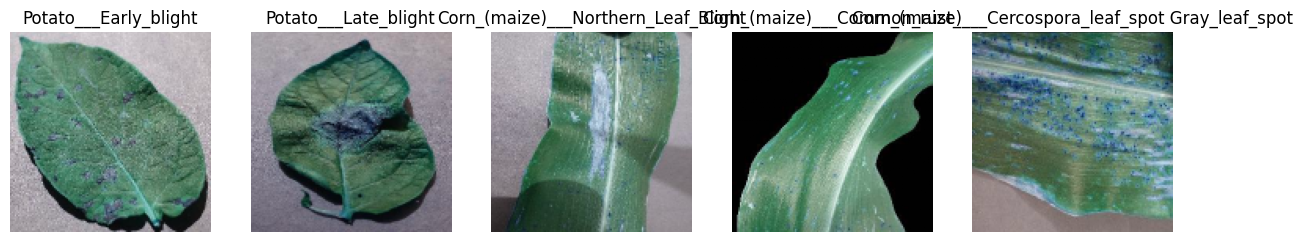

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(Plants[np.argmax(Y_train[i])])

In [15]:
from tensorflow.keras.regularizers import l2

In [16]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(num_classes,kernel_regularizer=l2(0.01),activation = "softmax"))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)              

In [17]:
model.compile(optimizer="adam",loss="squared_hinge", metrics = ['accuracy'])
hist = model.fit(X_train,Y_train,epochs=50,batch_size=10,validation_data=(X_test,Y_test))


Epoch 1/50


358/358 [==============================] - 14s 29ms/step - loss: 1.1186 - accuracy: 0.4853 - val_loss: 1.0395 - val_accuracy: 0.6664
Epoch 2/50
358/358 [==============================] - 8s 23ms/step - loss: 1.0161 - accuracy: 0.7276 - val_loss: 1.0072 - val_accuracy: 0.7427
Epoch 3/50
358/358 [==============================] - 8s 22ms/step - loss: 0.9904 - accuracy: 0.8013 - val_loss: 0.9913 - val_accuracy: 0.7883
Epoch 4/50
358/358 [==============================] - 8s 22ms/step - loss: 0.9755 - accuracy: 0.8419 - val_loss: 0.9746 - val_accuracy: 0.8397
Epoch 5/50
358/358 [==============================] - 8s 22ms/step - loss: 0.9625 - accuracy: 0.8771 - val_loss: 0.9700 - val_accuracy: 0.8521
Epoch 6/50
358/358 [==============================] - 8s 23ms/step - loss: 0.9577 - accuracy: 0.8902 - val_loss: 0.9591 - val_accuracy: 0.8827
Epoch 7/50
358/358 [==============================] - 8s 22ms/step - loss: 0.9512 - accuracy: 0.9078 - val_loss: 0.9630 - val_accuracy: 0.

In [18]:
model.evaluate(X_test, Y_test)
model.save("C:\\Users\\HEMA SAI VENKAT\\Desktop\\project IV\\TK55671\\CODE\\models\\SVC.h5")

48/48 [==============================] - 1s 12ms/step - loss: 0.9547 - accuracy: 0.8762


C:\Users\HEMA SAI VENKAT\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


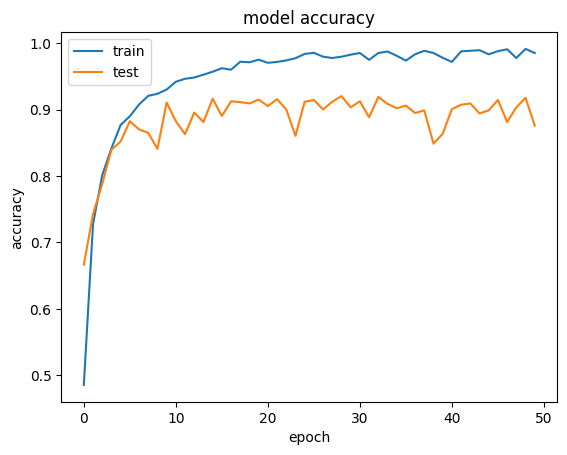

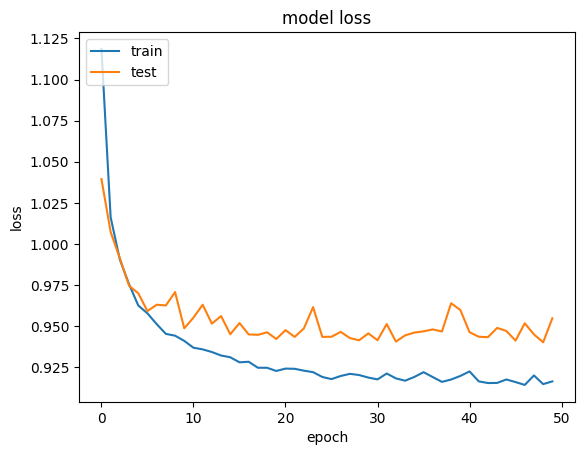

In [19]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from tensorflow import keras

In [23]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [128, 128,3]),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6291584   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 11)                363       
                                                                 
Total params: 6302283 (24.04 MB)
Trainable params: 6302283 (24.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist1=model1.fit(X_train,Y_train,epochs=50,batch_size=5,validation_data=(X_test,Y_test))

Epoch 1/50
716/716 [==============================] - 58s 78ms/step - loss: 2.3115 - accuracy: 0.2925 - val_loss: 1.4891 - val_accuracy: 0.4743
Epoch 2/50
698/716 [============================>.] - ETA: 40s - loss: 1.5443 - accuracy: 0.4501

KeyboardInterrupt: 

In [21]:
model1.evaluate(X_test, Y_test)
model1.save("C:\\Users\\HEMA SAI VENKAT\\Desktop\\project IV\\TK55671\\CODE\\models\\ANN.h5")

48/48 [==============================] - 1s 7ms/step - loss: 0.8324 - accuracy: 0.7199


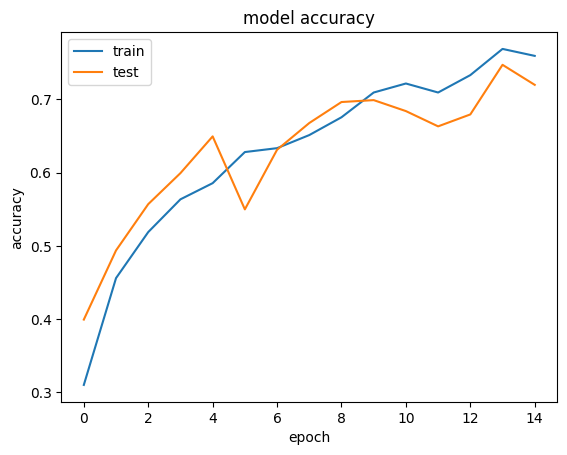

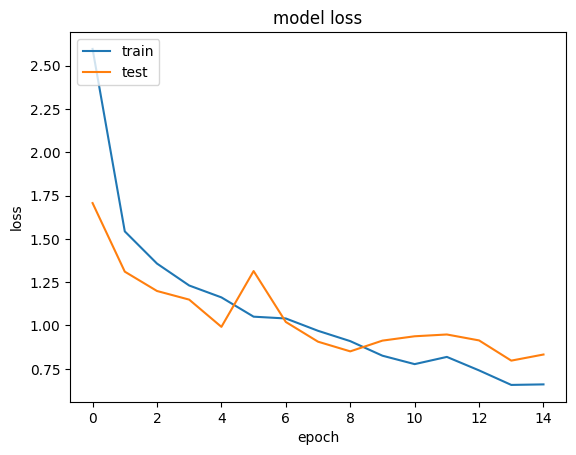

In [22]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model2 = Sequential()

model2.add(Conv2D(128, kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
model2.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 64)      73792     
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 32)      18464     
                                                                 
 flatten_2 (Flatten)         (None, 476288)            0         
                                                                 
 dense_6 (Dense)             (None, 11)                5239179   
                                                                 
Total params: 5335019 (20.35 MB)
Trainable params: 5335019 (20.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist2=model2.fit(X_train,Y_train,epochs=5,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/5
358/358 [==============================] - 245s 679ms/step - loss: 1.9672 - accuracy: 0.3604 - val_loss: 1.6291 - val_accuracy: 0.4899
Epoch 2/5
358/358 [==============================] - 237s 663ms/step - loss: 1.3947 - accuracy: 0.5851 - val_loss: 1.5785 - val_accuracy: 0.5336
Epoch 3/5
358/358 [==============================] - 233s 652ms/step - loss: 0.7627 - accuracy: 0.7773 - val_loss: 1.9928 - val_accuracy: 0.5596
Epoch 4/5
358/358 [==============================] - 239s 667ms/step - loss: 0.3346 - accuracy: 0.9139 - val_loss: 2.2727 - val_accuracy: 0.5987
Epoch 5/5
358/358 [==============================] - 237s 661ms/step - loss: 0.1394 - accuracy: 0.9693 - val_loss: 2.8658 - val_accuracy: 0.5993


In [25]:
model2.evaluate(X_test, Y_test)
model2.save("C:\\Users\\HEMA SAI VENKAT\\Desktop\\project IV\\TK55671\\CODE\\models\\CNN.h5")

48/48 [==============================] - 18s 372ms/step - loss: 2.8658 - accuracy: 0.5993


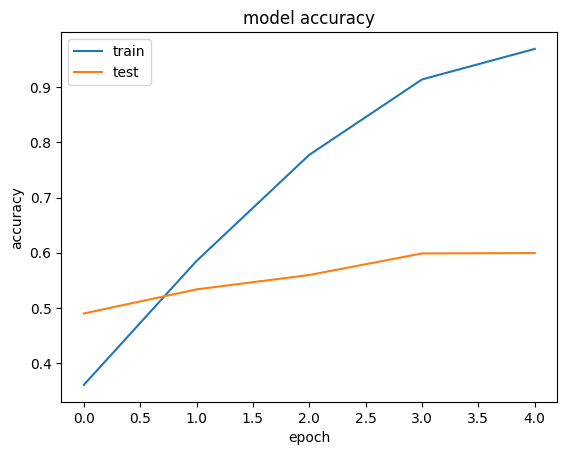

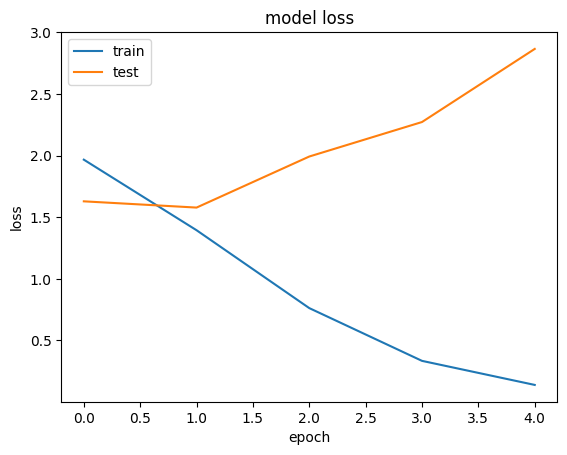

In [26]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
base_model3 = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False,
                          weights='imagenet')
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(num_classes, activation='sigmoid'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_7 (Dense)             (None, 64)                131136    
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 11)               

In [28]:
model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist3=model3.fit(X_train,Y_train,epochs=5,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/5
358/358 [==============================] - 340s 864ms/step - loss: 0.8810 - accuracy: 0.7184 - val_loss: 3.2987 - val_accuracy: 0.0899
Epoch 2/5
358/358 [==============================] - 304s 850ms/step - loss: 0.3978 - accuracy: 0.8754 - val_loss: 6.9196 - val_accuracy: 0.0945
Epoch 3/5
358/358 [==============================] - 292s 815ms/step - loss: 0.3234 - accuracy: 0.8952 - val_loss: 0.4728 - val_accuracy: 0.8521
Epoch 4/5
358/358 [==============================] - 297s 830ms/step - loss: 0.2401 - accuracy: 0.9246 - val_loss: 0.6164 - val_accuracy: 0.8280
Epoch 5/5
358/358 [==============================] - 295s 824ms/step - loss: 0.2179 - accuracy: 0.9262 - val_loss: 0.5168 - val_accuracy: 0.8130


In [29]:
model3.evaluate(X_test, Y_test)
model3.save("C:\\Users\\HEMA SAI VENKAT\\Desktop\\project IV\\TK55671\\CODE\\models\\ResNet50.h5")

48/48 [==============================] - 28s 586ms/step - loss: 0.5168 - accuracy: 0.8130


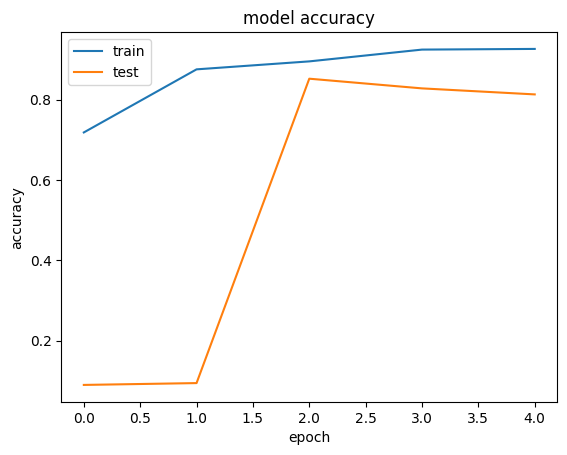

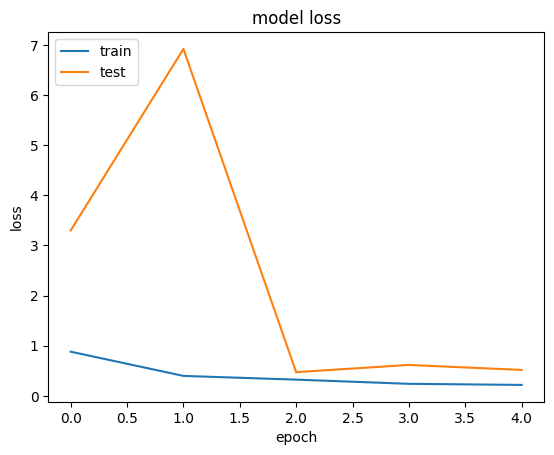

In [32]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
Accuracy = []

for i in [hist, hist1, hist2,hist3]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

[0.9513830542564392,
 0.7594299912452698,
 0.9692651629447937,
 0.9262363910675049]

1/1 [==============================] - 0s 423ms/step
[9.7717056e-03 1.7644198e-06 1.5189621e-06 4.0402260e-06 2.6566311e-04
 9.0921366e-01 4.3168437e-02 2.0555217e-02 3.1993361e-03 1.3561753e-02
 2.5690059e-04]


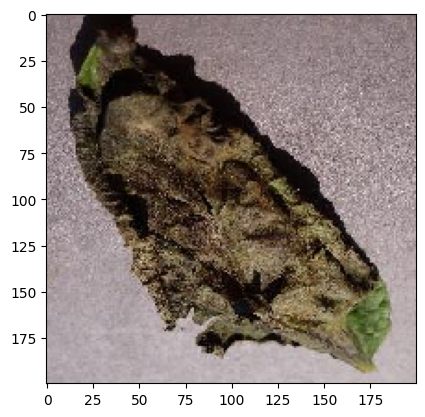

Prediction: Potato___healthy


In [34]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(r'C:\\Users\\HEMA SAI VENKAT\\Desktop\\project IV\\TK55671\\CODE\\data\\Potato___Late_blight\\8b0ef54c-6d28-47bb-a657-287afbb8a620___RS_LB 3298.jpg', grayscale=False, target_size=(128,128,3))
show_img=image.load_img(r'C:\\Users\\HEMA SAI VENKAT\\Desktop\\project IV\\TK55671\\CODE\\data\\Potato___Late_blight\\8b0ef54c-6d28-47bb-a657-287afbb8a620___RS_LB 3298.jpg', grayscale=False, target_size=(200, 200,3))
Plants = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model1.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Plants[ind])